In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import obspy
import os
import glob
import json
import numpy as np

from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
import matplotlib.dates as mdates
import matplotlib as mpl
import datetime

from obspy import UTCDateTime
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from obspy.signal import PPSD
from obspy.clients.arclink.client import Client
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


/home/diogoloc/programs/anaconda3/lib/python3.7/site-packages/obspy/clients/arclink/__init__.py:178: ObsPyDeprecationWarning: The ArcLink protocol will be deprecated in the near future. Please, use the client contacting the routing service provided by EIDA: https://docs.obspy.org/packages/obspy.clients.fdsn.html#basic-routing-clients-usage
  warnings.warn(msg, category=ObsPyDeprecationWarning)


# STATIONs DATA

In [3]:
#Location,OBS,Latitude,Longitude,Depth,Date
#1,21,25°36.5352S 43°2.3486W 2116m 04/08/2019 09:00
#2,17,25°29.4058S 42°36.8792W 2135m 27/07/2019 04:50
#3,18,24°33.2667S 42°31.0872W 1747m 28/07/2019 10:37
#4,22,22°31.5231S 39°50.7157W 1986m 01/08/2019 09:00
#5,20,21°56.1179S 39°39.2846W 1942m 02/08/2019 02:30
#6,19,21°16.3103S 40°6.8231W 1059m 02/08/2019 10:00

In [4]:
#ID;NAME;STATUS;LAT;LON;ELEV
#1517;OBS21;FUNDO;-25.60892;-43.039143333333;2116
#1520;OBS17;OK;-25.490096666667;-42.614653333333;2135
#1518;OBS18;SEMI;-24.554445;-42.51812;1747
#1519;OBS22;FUNDO;-22.525385;-39.845261666667;1986
#1573;OBS20;SEMI;-21.935298333333;-39.654743333333;1942
#1516;OBS19;OK;-21.271838333333;-40.113718333333;1059

In [5]:
#NAME;SIGLA;STATUS;LAT;LON;ELEV
#SAPINHOÁ;OBS21;FUNDO;-25.60892;-43.039143333333;2116
#LULA;OBS17;OK;-25.490096666667;-42.614653333333;2135
#BUZIOS;OBS18;SEMI;-24.554445;-42.51812;1747
#MARLIN;OBS22;FUNDO;-22.525385;-39.845261666667;1986
#RONCADOR;OBS20;SEMI;-21.935298333333;-39.654743333333;1942
#JUBARTE;OBS19;OK;-21.271838333333;-40.113718333333;1059

# Configuration file


In [54]:
FILES_DIR = '/home/diogoloc/Insync/locdiogo@gmail.com/OneDrive - Shared/OBS_Dados/'
FIGURE_DIR = '/home/diogoloc/dados_posdoc/ON_MAR/obs_data/Figuras_avaliacao/'

OBS_NAME = 'OBS_Jubarte'
SENSOR_NAME = '1516'

DEPLOY_DAY = UTCDateTime('2019-08-02') #roncador
RECOVER_DAY = UTCDateTime('2020-06-17') #roncador

#DEPLOY_DAY = UTCDateTime('2019-08-02') #roncador
#RECOVER_DAY = UTCDateTime('2020-06-16') #roncador

#DEPLOY_DAY = UTCDateTime('2019-07-27') #buzios
#RECOVER_DAY = UTCDateTime('2020-06-15') #buzios

#DEPLOY_DAY = UTCDateTime('2019-08-02') #lula
#RECOVER_DAY = UTCDateTime('2020-06-14') #lula


# ================
# MULTIPROCESSING
# ================
num_processes = 12

# Função para procurar arquivos: 

In [55]:
def filelist(basedir,ext):
    """
    Returns the list of files in *basedir* whose are in the specified period
    """
    files = []
    for folder in os.listdir(basedir):
        if folder.endswith(ext):
            print(folder)
            folder_path = os.path.join(basedir, folder)
            s = glob.glob(folder_path+'/*')
            files.append(s)
    files = sorted(files)
    return files

# Mass Positions

In [56]:
files = filelist(FILES_DIR+OBS_NAME,'00')

151600


In [57]:
files_sensor = sorted([item for sublist in files for item in sublist if SENSOR_NAME in item])

In [58]:
Mass_Position_line = []
for i in files_sensor:
    with open(i,'r',encoding='latin-1') as f:
        lines = f.readlines()
        Mass_Position_line.append([k for k in lines if 'Mass Positions' in k])
        f.close()

In [59]:
Mass_Position_lines = [item for sublist in Mass_Position_line for item in sublist]

In [60]:
time_x = []
pos_Z = []
pos_N = []
pos_E = []

for i in Mass_Position_lines:
    time = UTCDateTime(i.split(' Mass Positions ')[0])
    time_x.append(datetime.date(time.year,time.month,time.day))
    pos_Z.append(float(i.split(' Mass Positions ')[1].split('%')[0]))
    pos_N.append(float(i.split(' Mass Positions ')[1].split('%')[1]))
    pos_E.append(float(i.split(' Mass Positions ')[1].split('%')[2]))

## CENTRE UNIT

In [61]:
CENTRE_line = []
for i in files_sensor:
    with open(i,'r',encoding='latin-1') as f:
        lines = f.readlines()
        CENTRE_line.append([k for k in lines if 'CENTRE UNIT' in k])
        f.close()

In [62]:
CENTRE_lines = [item for sublist in CENTRE_line for item in sublist]

time_x_center = []
pos_center = []

for i in CENTRE_lines:
    time = UTCDateTime(i.split(' CENTRE UNIT ')[0])
    time_x_center.append(datetime.date(time.year,time.month,time.day))
    pos_center.append(0)

### Ploting DATA

Locator attempting to generate 1075 ticks ([737225.0, ..., 738299.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1075 ticks ([737225.0, ..., 738299.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1075 ticks ([737225.0, ..., 738299.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1075 ticks ([737225.0, ..., 738299.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1075 ticks ([737225.0, ..., 738299.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1075 ticks ([737225.0, ..., 738299.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1075 ticks ([737225.0, ..., 738299.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1075 ticks ([737225.0, ..., 738299.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1075 ticks ([737225.0, ..., 738299.0]), which exceeds Locator.MAXTICKS (1000).
Locator at

Locator attempting to generate 1075 ticks ([737225.0, ..., 738299.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1075 ticks ([737225.0, ..., 738299.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1075 ticks ([737225.0, ..., 738299.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1075 ticks ([737225.0, ..., 738299.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1075 ticks ([737225.0, ..., 738299.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1075 ticks ([737225.0, ..., 738299.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1075 ticks ([737225.0, ..., 738299.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1075 ticks ([737225.0, ..., 738299.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1075 ticks ([737225.0, ..., 738299.0]), which exceeds Locator.MAXTICKS (1000).
Locator at

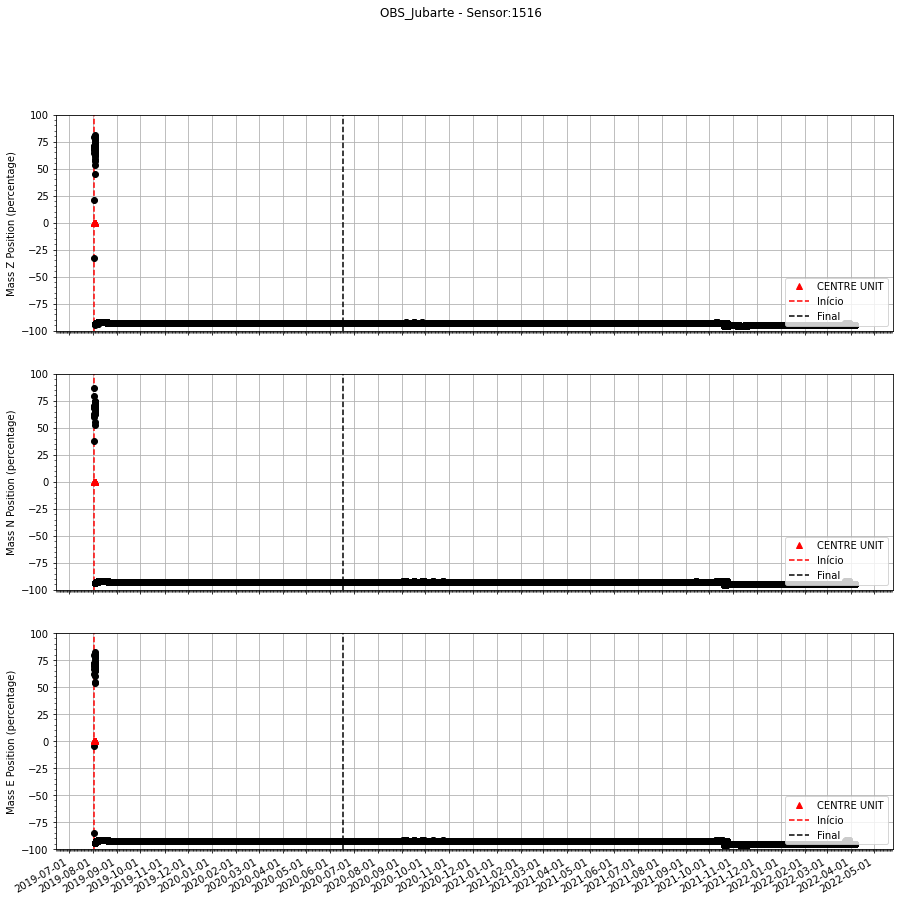

In [63]:
days = DayLocator()   # every year
months = MonthLocator()  # every month
yearsFmt = DateFormatter('%Y-%m-%d')

fig, (ax,ax1,ax2) = plt.subplots(nrows=3,ncols=1,figsize=(15,15))



ax.vlines(datetime.date(DEPLOY_DAY.year,DEPLOY_DAY.month,DEPLOY_DAY.day),-100,100,colors='r',linestyles='dashed',label='Início')
ax.vlines(datetime.date(RECOVER_DAY.year,RECOVER_DAY.month,RECOVER_DAY.day),-100,100,colors='k',linestyles='dashed',label='Final')
ax.plot(time_x, pos_Z,'ok')
ax.plot(time_x_center, pos_center,'^r',label='CENTRE UNIT')

ax.set_ylabel('Mass Z Position (percentage)')
ax.set_ylim(-100,100)
ax.yaxis.set_major_locator(MultipleLocator(25))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(days)
ax.legend(loc='lower right')
ax.grid(True)

ax1.vlines(datetime.date(DEPLOY_DAY.year,DEPLOY_DAY.month,DEPLOY_DAY.day),-100,100,colors='r',linestyles='dashed',label='Início')
ax1.vlines(datetime.date(RECOVER_DAY.year,RECOVER_DAY.month,RECOVER_DAY.day),-100,100,colors='k',linestyles='dashed',label='Final')
ax1.plot(time_x, pos_N,'ok')
ax1.plot(time_x_center, pos_center,'^r',label='CENTRE UNIT')

ax1.set_ylabel('Mass N Position (percentage)')
ax1.set_ylim(-100,100)
ax1.yaxis.set_major_locator(MultipleLocator(25))
ax1.yaxis.set_minor_locator(MultipleLocator(5))
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(yearsFmt)
ax1.xaxis.set_minor_locator(days)
ax1.legend(loc='lower right')
ax1.grid(True)


ax2.vlines(datetime.date(DEPLOY_DAY.year,DEPLOY_DAY.month,DEPLOY_DAY.day),-100,100,colors='r',linestyles='dashed',label='Início')
ax2.vlines(datetime.date(RECOVER_DAY.year,RECOVER_DAY.month,RECOVER_DAY.day),-100,100,colors='k',linestyles='dashed',label='Final')
ax2.plot(time_x, pos_E,'ok')
ax2.plot(time_x_center, pos_center,'^r',label='CENTRE UNIT')

ax2.set_ylabel('Mass E Position (percentage)')
ax2.set_ylim(-100,100)
ax2.yaxis.set_major_locator(MultipleLocator(25))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
ax2.xaxis.set_major_locator(months)
ax2.xaxis.set_major_formatter(yearsFmt)
ax2.xaxis.set_minor_locator(days)
ax2.legend(loc='lower right')
ax2.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

fig.suptitle(OBS_NAME+' - Sensor:'+SENSOR_NAME)
fig.savefig(FIGURE_DIR+OBS_NAME+'_MASS_POSITIONS.png', dpi=300, facecolor='w')

# Temperature

In [64]:
temperature_line = []
system_reboot_line = [] 
for i in files_sensor:
    with open(i,'r',encoding='latin-1') as f:
        lines = f.readlines()
        temperature_line.append([k for k in lines if 'Temperature' in k])
        system_reboot_line.append([k for k in lines if 'System re-boot at ' in k])
        f.close()

In [65]:
temperature_lines = [item for sublist in temperature_line for item in sublist]
system_reboot_lines = [item for sublist in system_reboot_line for item in sublist]

In [66]:
temperature = []

for i in temperature_lines:
    temperature.append(float((i.split('Temperature')[1].split('C')[0]).split("'")[0]))

In [67]:
time_x_temp = []
for i in system_reboot_lines:
    time_temp = UTCDateTime(i.split('at')[1].split('\n')[0])
    time_x_temp.append(datetime.date(time_temp.year,time_temp.month,time_temp.day))

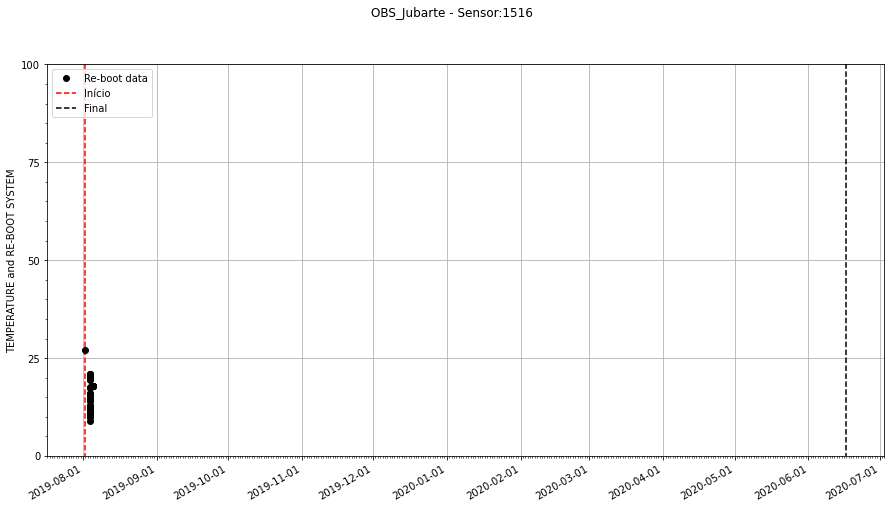

In [68]:
days = DayLocator()   # every year
months = MonthLocator()  # every month
yearsFmt = DateFormatter('%Y-%m-%d')

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(15,8))

ax.vlines(datetime.date(DEPLOY_DAY.year,DEPLOY_DAY.month,DEPLOY_DAY.day),-100,100,colors='r',linestyles='dashed',label='Início')
ax.vlines(datetime.date(RECOVER_DAY.year,RECOVER_DAY.month,RECOVER_DAY.day),-100,100,colors='k',linestyles='dashed',label='Final')
ax.plot(time_x_temp, temperature,'ok',label='Re-boot data')

ax.set_ylabel('TEMPERATURE and RE-BOOT SYSTEM')
ax.set_ylim(0,100)
ax.yaxis.set_major_locator(MultipleLocator(25))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(days)
ax.legend(loc='upper left')
ax.grid(True)


# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

fig.suptitle(OBS_NAME+' - Sensor:'+SENSOR_NAME)
fig.savefig(FIGURE_DIR+OBS_NAME+'_TEMPERATURE_REBOOT.png', dpi=300, facecolor='w')